In [1]:
import os, datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
#from dtaidistance import dtw_visualisation as dtwvis
from utils.Dataset import CraneDataset, normalize_train_dataset, normalize_val_dataset, create_lstm_dataset
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
#from dtaidistance import dtw
from tqdm.notebook import tqdm


In [2]:
data_file_path_list = []
data_file_name_list = os.listdir('data')

for file_name in data_file_name_list:
    data_file_path_list.append(os.path.join('data', file_name))

#### load dataset

In [3]:
dataset_inst = CraneDataset(data_file_path_list)
raw_dataset = dataset_inst.get_dataset()

feature_names = dataset_inst.get_data_feature_names()
target_names = dataset_inst.get_data_target_names()

for t_name in target_names:
    raw_dataset[t_name] = raw_dataset[t_name]/1000

for t_name in target_names:
    raw_dataset = raw_dataset[raw_dataset[t_name]>1]

for name in feature_names[3:6]:
    raw_dataset[name] = raw_dataset[name]*1000
    
raw_dataset = raw_dataset[raw_dataset['Time(sec)'] > 4]

raw_dataset = raw_dataset[::10]
raw_dataset.reset_index(drop=True, inplace=True)

grad_boom_angle = np.gradient(raw_dataset['Boom_Angle(deg)'])
grad_swing_angle = np.gradient(raw_dataset['Swing_Angle(deg)'])
grad_roll_angle = np.gradient(raw_dataset['Roll_Angle(deg)'])
grad_pitch_angle = np.gradient(raw_dataset['Pitch_Angle(deg)'])

extra_feature_name_list = ['grad_boom_angle', 'grad_swing_angle', 'grad_roll_angle', 'grad_pitch_angle']
new_feature_names = feature_names + extra_feature_name_list

for extra_feature_name, extra_feature  in zip(extra_feature_name_list, [grad_boom_angle, grad_swing_angle, grad_roll_angle, grad_pitch_angle]):
    raw_dataset[extra_feature_name] = extra_feature

train_dataset_1 = raw_dataset[raw_dataset['dataset_type'] == 0]
train_dataset = train_dataset_1.drop(columns=['Time(sec)', 'file_idx', 'safe_state', 'dataset_type'])
train_dataset = train_dataset[new_feature_names[0:4]+new_feature_names[5:10]+ target_names]

val_dataset_1 = raw_dataset[raw_dataset['dataset_type'] == 1]
val_dataset = val_dataset_1.drop(columns=['Time(sec)', 'file_idx', 'safe_state', 'dataset_type'])
val_dataset = val_dataset[new_feature_names[0:4]+new_feature_names[5:10]+ target_names]

  0%|          | 0/22 [00:00<?, ?it/s]

#### display for raw data(train, validation)

Text(0, 0.5, 'value')

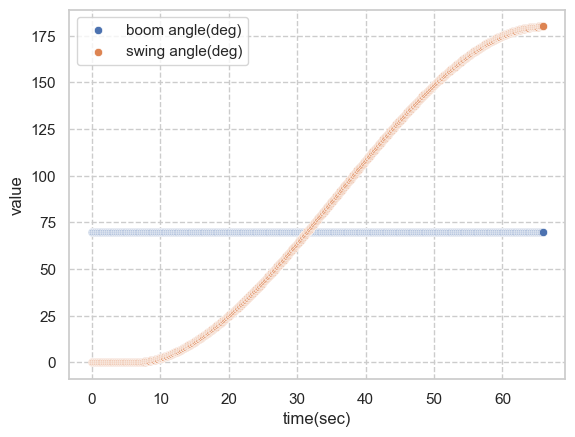

In [4]:
file_index = 4
sliced_dataset = raw_dataset[raw_dataset['file_idx']==file_index]
time_arr = np.arange(0, (sliced_dataset.shape[0])*0.1, 0.1)

sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(x=time_arr, y=sliced_dataset['Boom_Angle(deg)'], label='boom angle(deg)')
sns.scatterplot(x=time_arr, y=sliced_dataset['Swing_Angle(deg)'], label='swing angle(deg)')

plt.grid(True)
plt.xlabel('time(sec)')
plt.ylabel('value')

Text(0, 0.5, 'Left Side Load(KN)')

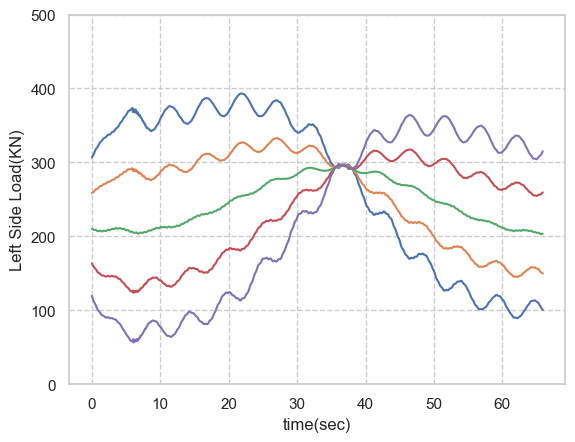

In [5]:
file_index = 2
sliced_dataset = raw_dataset[raw_dataset['file_idx']==file_index]
time_arr = np.arange(0, (sliced_dataset.shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

for i in range(5):
    sns.lineplot(x=time_arr, y=sliced_dataset[target_names[i]]) 

plt.xlabel('time(sec)')
plt.ylim(0, 500)
plt.ylabel('Left Side Load(KN)')

Text(0, 0.5, 'Right Side Load(KN)')

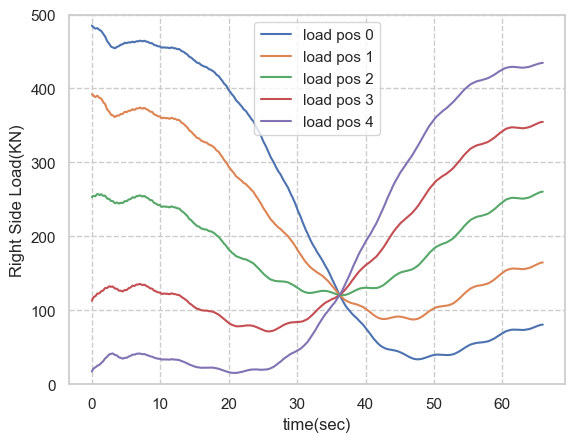

In [6]:
file_index = 4
sliced_dataset = raw_dataset[raw_dataset['file_idx']==file_index]
time_arr = np.arange(0, (sliced_dataset.shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

for i in range(5):
    sns.lineplot(x=time_arr, y=sliced_dataset[target_names[i+5]], label=f'load pos {i}') 

plt.xlabel('time(sec)')
plt.ylim(0, 500)
plt.ylabel('Right Side Load(KN)')

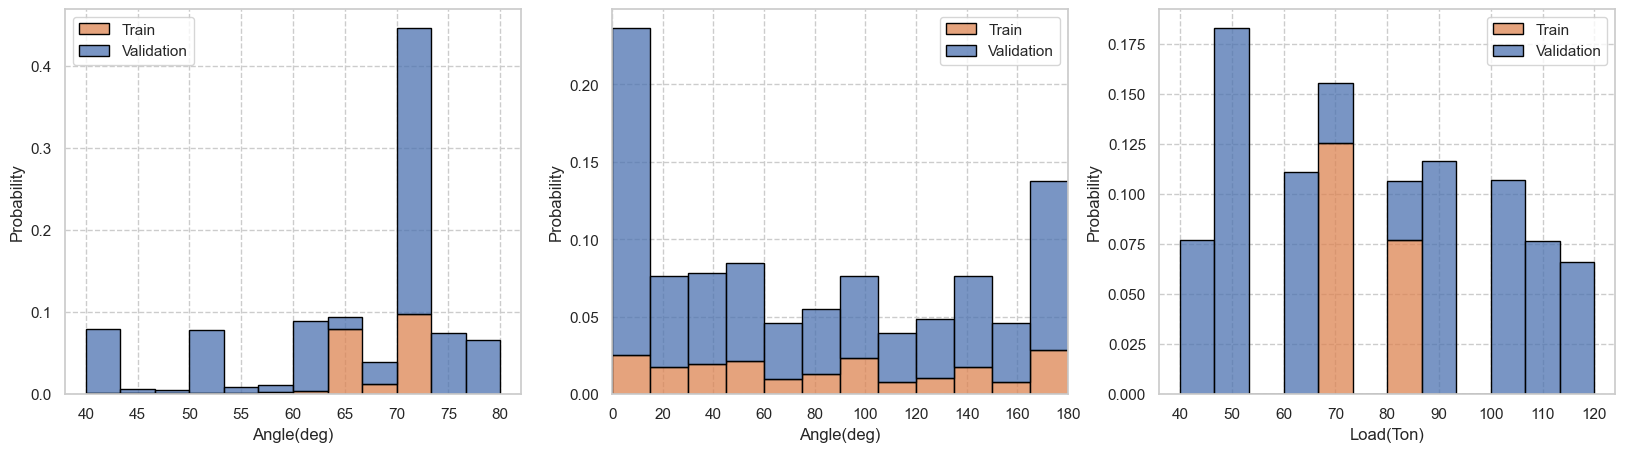

In [7]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

fig, axis = plt.subplots(ncols=3)
fig.set_size_inches(20, 5)

sns.histplot(data=raw_dataset, x='Boom_Angle(deg)', stat='probability', multiple='stack', bins=12, edgecolor='black', hue='dataset_type', ax=axis[0])
sns.histplot(data=raw_dataset, x='Swing_Angle(deg)', stat='probability', multiple='stack', bins=12, edgecolor='black', hue='dataset_type', ax=axis[1])
sns.histplot(data=raw_dataset, x='Load(Ton)', stat='probability', multiple='stack', bins=12, edgecolor='black', hue='dataset_type', ax=axis[2])

axis[0].set_xlabel('Angle(deg)')
axis[1].set_xlim(0, 180)
axis[1].set_xlabel('Angle(deg)')
axis[2].set_xlabel('Load(Ton)')

for i in range(3):
    axis[i].legend(['Train', 'Validation'])

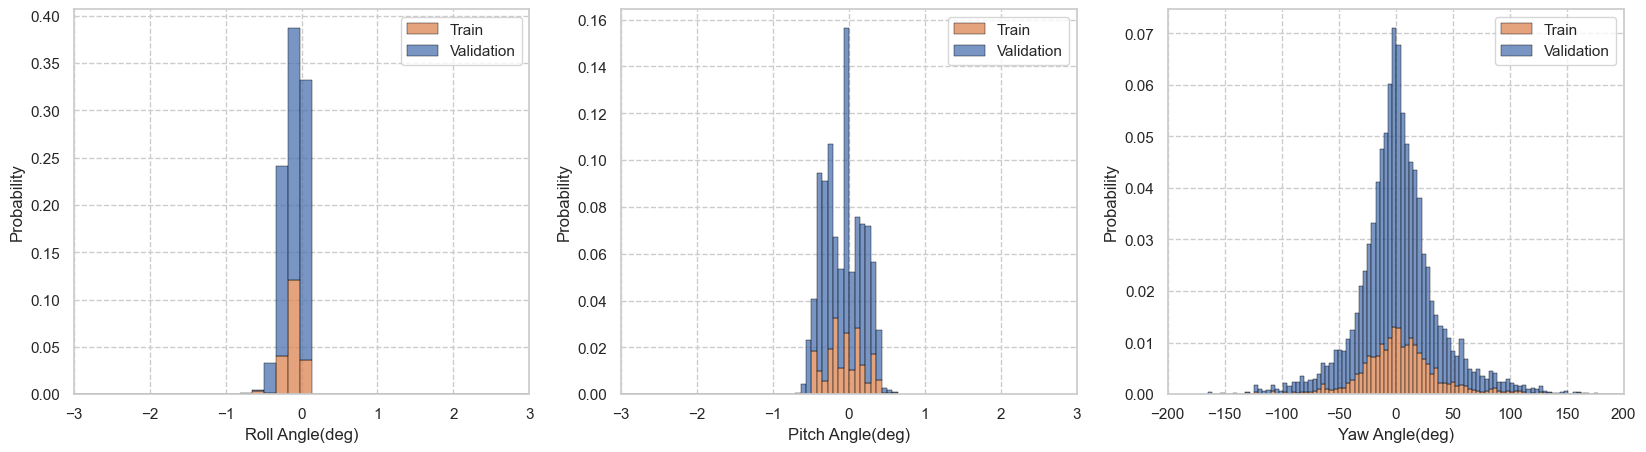

In [8]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

fig, axis = plt.subplots(ncols=3)
fig.set_size_inches(20, 5)

sns.histplot(data=raw_dataset, x='Roll_Angle(deg)', stat='probability', multiple='stack', bins=100, edgecolor='black', hue='dataset_type', ax=axis[0])
sns.histplot(data=raw_dataset, x='Pitch_Angle(deg)', stat='probability', multiple='stack', bins=100, edgecolor='black', hue='dataset_type', ax=axis[1])
sns.histplot(data=raw_dataset, x='Yaw_Angle(deg)', stat='probability', multiple='stack', bins=100, edgecolor='black', hue='dataset_type', ax=axis[2])

axis[0].set_xlim(-3, 3)
axis[0].set_xlabel('Roll Angle(deg)')

axis[1].set_xlim(-3, 3)
axis[1].set_xlabel('Pitch Angle(deg)')

axis[2].set_xlim(-200, 200)
axis[2].set_xlabel('Yaw Angle(deg)')

for i in range(3):
    axis[i].legend(['Train', 'Validation'])

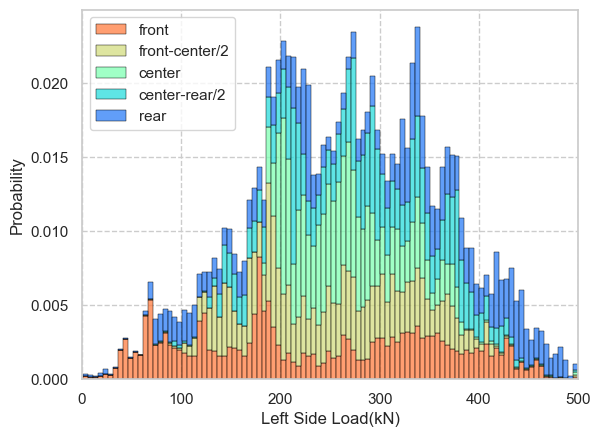

In [9]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.histplot(raw_dataset[target_names[0:5]], stat='probability', palette='rainbow', multiple='stack', bins=100, edgecolor='black')

plt.xlim(0, 500)
plt.xlabel('Left Side Load(kN)')

legend_name_list = ['front', 'front-center/2', 'center', 'center-rear/2', 'rear']

plt.legend(legend_name_list)

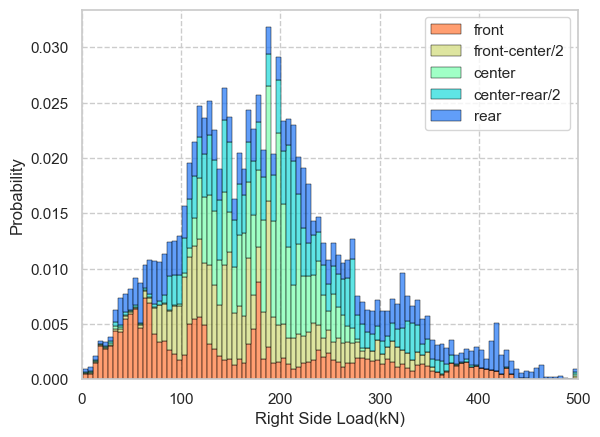

In [10]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.histplot(raw_dataset[target_names[5:10]], stat='probability', palette='rainbow', multiple='stack', bins=100, edgecolor='black')

plt.xlim(0, 500)
plt.xlabel('Right Side Load(kN)')

plt.legend(legend_name_list)

In [11]:
raw_dataset[raw_dataset['dataset_type']==0].describe()

,Time(sec),file_idx,safe_state,dataset_type,Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Roll_Angle(deg),Yaw_Angle(deg),Pitch_Angle(deg),...,Actual_Load_Left_5(N),Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N),grad_boom_angle,grad_swing_angle,grad_roll_angle,grad_pitch_angle
count,6828.000000,6828.000000,6828.000000,6828.0,6828.000000,6.828000e+03,6828.000000,6828.000000,6828.000000,6828.000000,...,6828.000000,6828.000000,6828.000000,6828.000000,6828.000000,6828.000000,6828.000000,6.828000e+03,6828.000000,6828.000000
mean,28.976908,7.444493,0.434241,0.0,64.730835,7.504707e+01,76.410369,-0.104390,2.161861,-0.077933,...,232.112782,223.410732,205.410112,187.512173,172.156667,161.769109,-0.003313,1.315543e-02,-0.000129,0.000079
std,18.064208,6.160848,0.495693,0.0,11.378208,6.340031e+01,26.379386,0.187215,36.894316,0.281903,...,122.579428,120.377243,74.691970,43.444260,68.944832,112.088830,0.573407,4.610255e+00,0.104061,0.057713
min,4.000253,0.000000,0.000000,0.0,40.000000,-6.351914e-27,40.000000,-8.407094,-164.854250,-6.458988,...,1.334470,1.048542,2.564975,4.721832,7.497771,1.318515,-5.000000,-9.000000e+01,-4.210119,-3.387895
25%,14.600253,2.000000,0.000000,0.0,60.000000,1.209191e+01,50.000000,-0.194059,-15.000072,-0.290230,...,122.276533,113.265355,142.262205,155.360085,117.819955,65.270054,0.000000,2.294913e-30,-0.001350,-0.001274
50%,24.660253,6.000000,0.000000,0.0,70.000000,6.303836e+01,70.000000,-0.071108,0.760224,-0.053333,...,208.072700,215.883870,205.293320,193.276570,161.859615,132.584120,0.000000,2.584050e-01,-0.000109,0.000344
75%,41.572753,12.000000,1.000000,0.0,70.000000,1.350000e+02,100.000000,-0.001182,18.447337,0.141469,...,340.407857,323.747382,261.779000,216.459888,207.050123,239.448020,0.000000,4.214209e-01,0.001045,0.003383
max,70.000000,21.000000,1.000000,0.0,80.000000,1.800000e+02,120.000000,7.421076,203.111110,0.648729,...,500.160870,500.071610,500.072530,500.075530,500.078830,500.082130,14.868984,7.513620e+00,5.430284,1.120383


In [12]:
raw_dataset[raw_dataset['dataset_type']==1].describe()

,Time(sec),file_idx,safe_state,dataset_type,Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Roll_Angle(deg),Yaw_Angle(deg),Pitch_Angle(deg),...,Actual_Load_Left_5(N),Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N),grad_boom_angle,grad_swing_angle,grad_roll_angle,grad_pitch_angle
count,1736.000000,1736.000000,1736.000000,1736.0,1736.000000,1.736000e+03,1736.000000,1736.000000,1736.000000,1736.000000,...,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000
mean,24.915806,10.849654,0.619816,1.0,67.001451,8.467407e+01,73.801843,-0.123863,4.801032,-0.047713,...,246.800580,202.949374,189.901603,178.102967,168.912048,163.687427,0.009907,0.000101,0.000025,-0.000229
std,16.323843,6.707034,0.485572,0.0,4.286080,5.749646e+01,4.855719,0.117568,36.801879,0.240006,...,112.400970,111.891600,68.078691,39.280520,65.851514,107.779024,0.780961,4.844354,0.015030,0.025005
min,4.000253,3.000000,0.000000,1.0,40.973739,-1.920470e-29,70.000000,-0.736461,-131.112650,-0.487143,...,33.495163,1.100294,6.023285,4.591641,3.347129,2.293287,-0.449932,-89.999970,-0.050150,-0.519177
25%,12.667753,3.000000,0.000000,1.0,65.000000,3.664034e+01,70.000000,-0.163923,-15.115608,-0.209669,...,160.552577,123.797792,148.184647,162.500690,130.525563,94.863051,0.000000,0.000000,-0.001860,-0.000772
50%,21.350253,11.000000,1.000000,1.0,69.602106,8.492907e+01,70.000000,-0.102187,2.270791,-0.038593,...,262.141270,179.017005,178.981405,181.431145,151.591965,123.622495,0.000000,0.285901,-0.000371,0.000830
75%,30.282753,17.000000,1.000000,1.0,70.000000,1.350000e+02,80.000000,-0.044665,21.167416,0.124289,...,320.439797,281.499550,230.334440,206.000632,210.279435,244.968835,0.000000,0.447666,0.001133,0.002896
max,69.970253,20.000000,1.000000,1.0,70.000000,1.800000e+02,80.000000,0.060575,174.277600,0.615554,...,474.582410,437.730080,342.262600,244.954960,366.290450,471.496210,14.911707,1.349934,0.414623,0.083649


In [13]:
load_data_flat = pd.DataFrame(raw_dataset[target_names[5:10]].to_numpy().reshape(-1, 1), columns=['load'])
load_data_flat['dataset_type'] = np.tile(raw_dataset['dataset_type'].to_numpy(), 5)

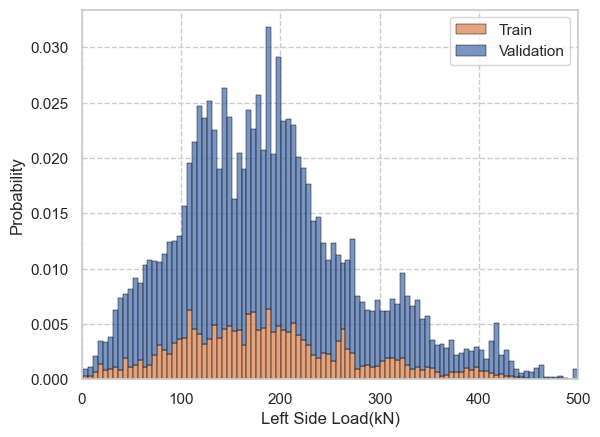

In [14]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.histplot(data=load_data_flat, x='load', hue='dataset_type', bins=100, stat='probability', multiple='stack', edgecolor='black')

plt.xlim(0, 500)
plt.xlabel('Left Side Load(kN)')

plt.legend(['Train', 'Validation'])

Text(0.5, 0, 'Angle(deg)')

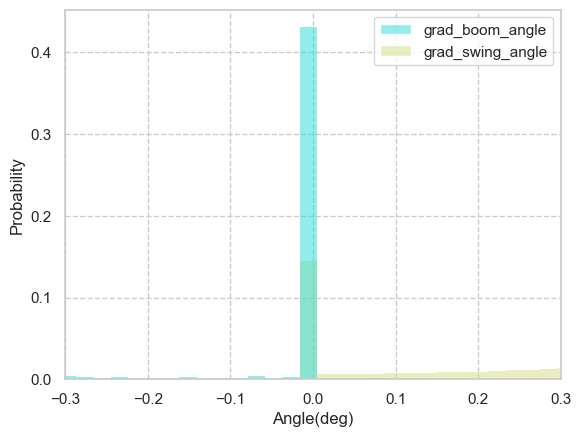

In [15]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.histplot(raw_dataset[['grad_boom_angle', 'grad_swing_angle']], stat='probability', palette='rainbow')

plt.xlim(-0.3, 0.3)
plt.xlabel('Angle(deg)')

#### data merge from feature extraction

In [16]:
seq_len = 30
pred_distance = 10
n_features = 19
hidden_size = 500
n_outputs = 10


def lstm_est_model():
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)

    input_tensor = keras.layers.Input(shape=(seq_len, n_features), dtype=tf.float32)
    input_flatten_layer = keras.layers.Flatten()(input_tensor)

    mean_tensor = tf.reduce_mean(input_tensor, axis=1)
    max_tensor = tf.reduce_max(input_tensor, axis=1)
    min_tensor = tf.reduce_min(input_tensor, axis=1)
    sum_tensor = tf.reduce_sum(input_tensor, axis=1)
    std_tensor = tf.math.reduce_std(input_tensor, axis=1)

    avg_low_bool = tf.less(input_tensor, tf.expand_dims(mean_tensor, axis=1))
    avg_low_count = tf.math.count_nonzero(avg_low_bool, axis=1, dtype=tf.float32)
    avg_high_count = tf.math.count_nonzero(tf.math.logical_not(avg_low_bool), axis=1, dtype=tf.float32)
    
    feature_eng_tensor = keras.layers.concatenate([mean_tensor, max_tensor, min_tensor, sum_tensor, std_tensor, avg_low_count, avg_high_count])
    
    # Convolutional Layers
    conv_layer = keras.layers.Conv1D(filters=64, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(input_tensor) 
    conv_layer = keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(conv_layer)
    conv_layer = keras.layers.Conv1D(filters=256, kernel_size=3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.03))(conv_layer)
    conv_layer = keras.layers.MaxPooling1D(pool_size=2)(conv_layer)
    fcn_layer = keras.layers.Flatten()(conv_layer)
    conv_output_layer = keras.layers.Dense(seq_len*2, activation='relu')(fcn_layer)    
   
    # LSTM Layers
    lstm_layer = keras.layers.Bidirectional(keras.layers.LSTM(units=hidden_size, return_sequences=False, name='bidirectional_lstm'))(tf.expand_dims(conv_output_layer, axis=1))

    # Concatenation of all features
    concat_tensor = keras.layers.concatenate([lstm_layer, feature_eng_tensor], axis=-1)

    # Output Layer
    output_tensor = keras.layers.Dense(1000, activation='linear')(concat_tensor)
    output_tensor = keras.layers.Dense(n_outputs, activation='linear')(output_tensor)

    # Model Compilation
    model = keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

    return model

In [19]:
model = lstm_est_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 19)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 26, 64)       6144        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 22, 128)      41088       ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 20, 256)      98560       ['conv1d_1[0][0]']               
                                                                                              

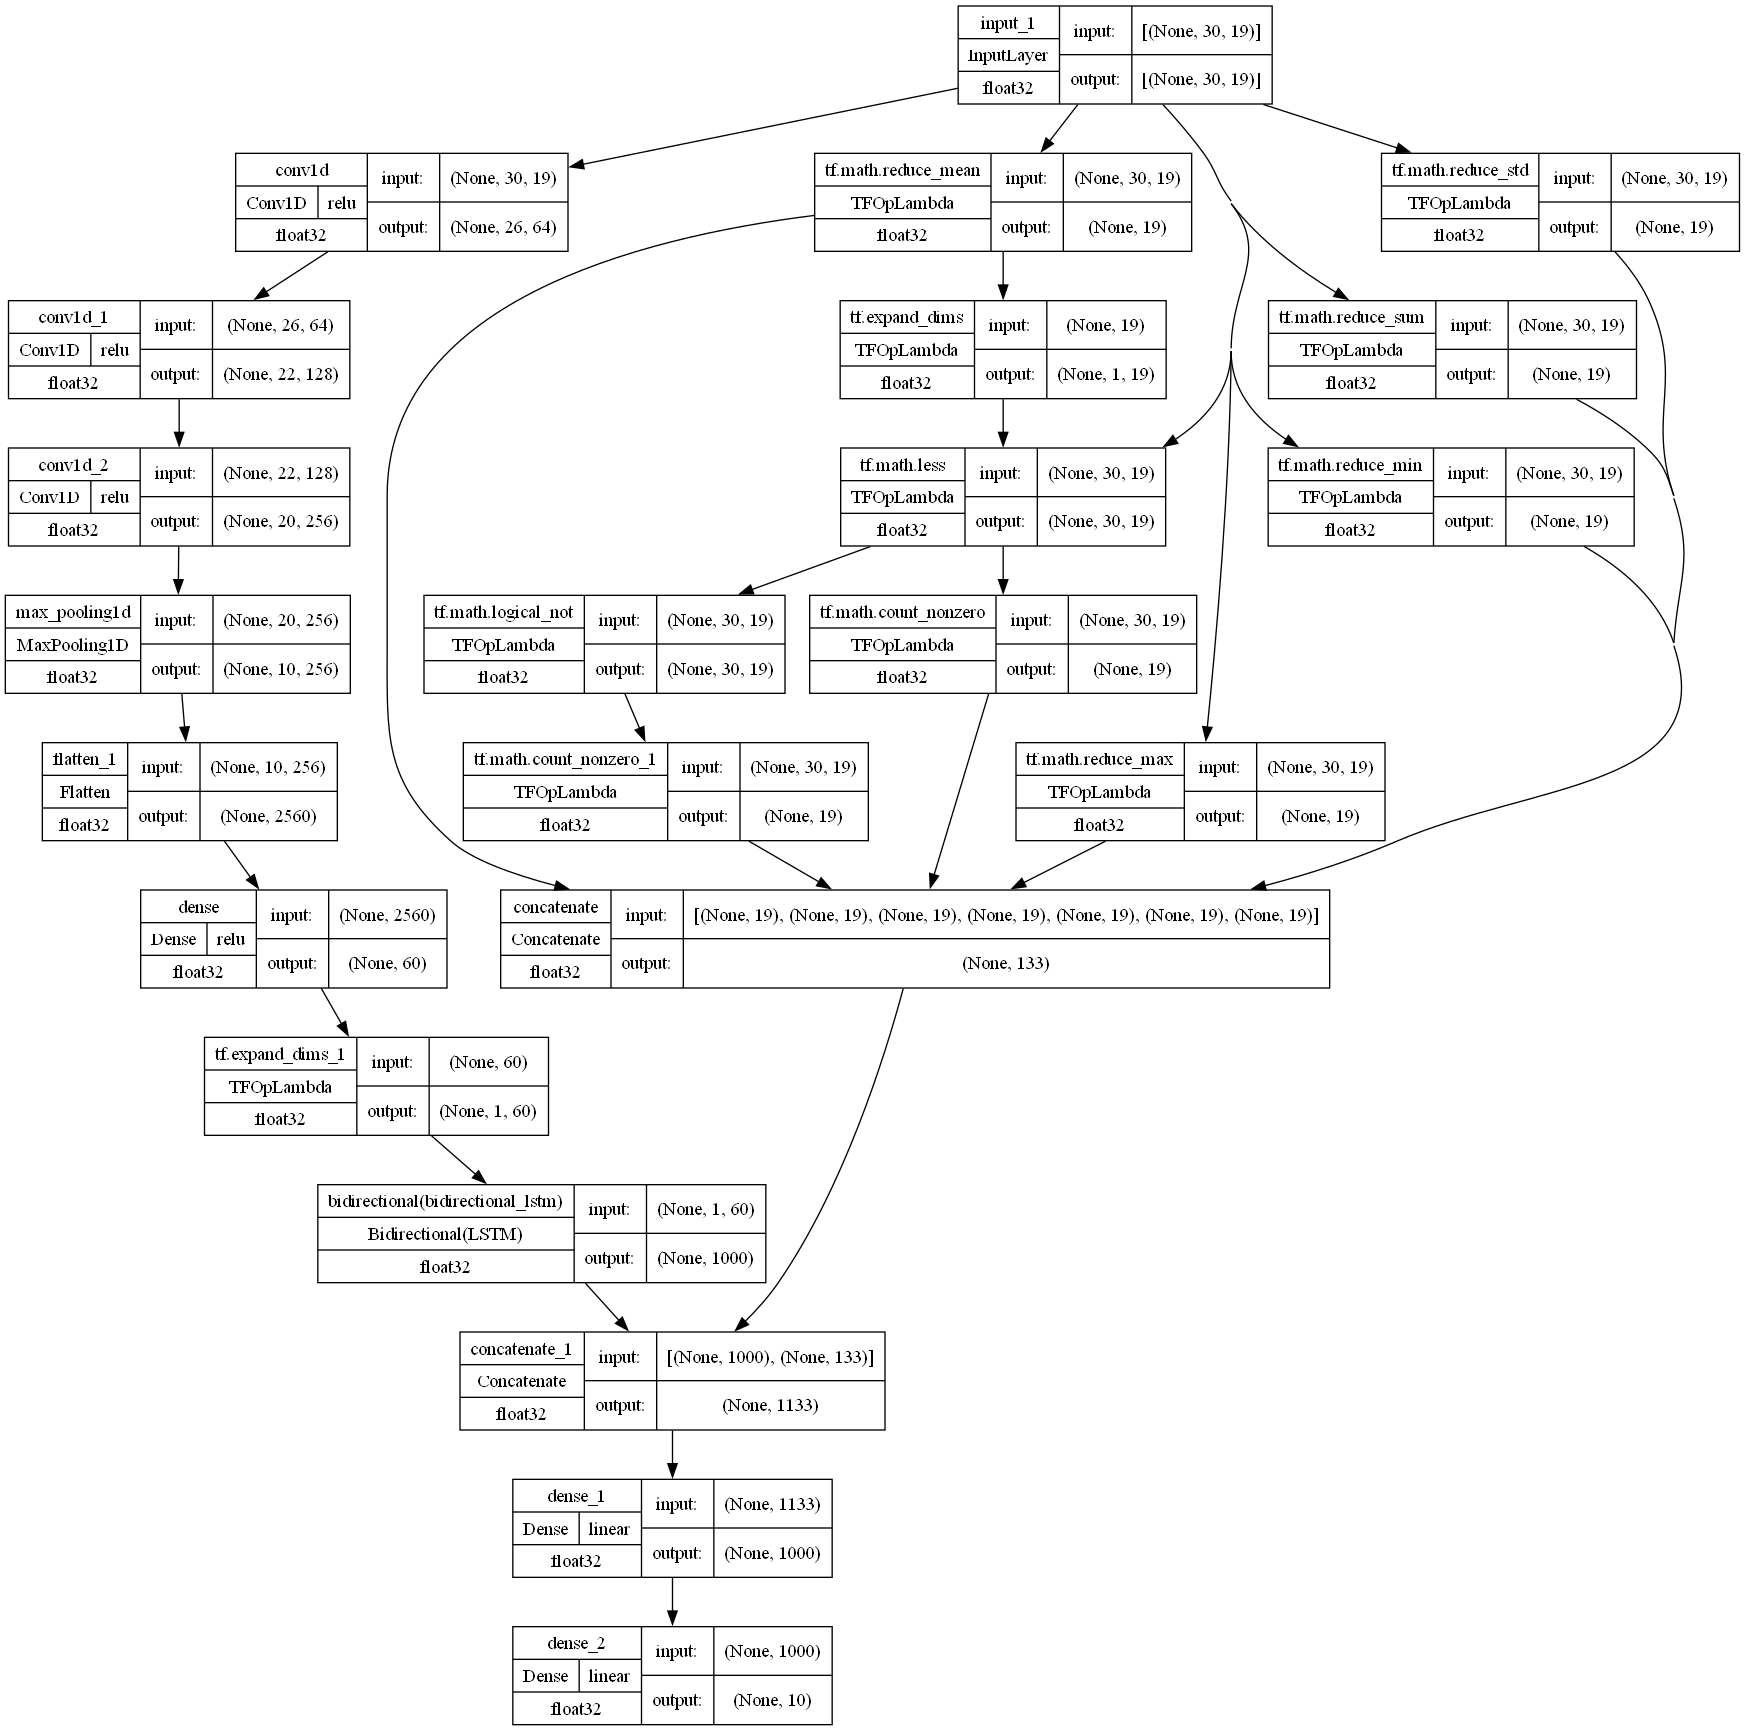

In [17]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [20]:
train_feature, train_target = create_lstm_dataset(train_dataset.to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=9)
val_feature, val_target = create_lstm_dataset(val_dataset.to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=9)
    
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, verbose=0)
csv_logger = keras.callbacks.CSVLogger(os.path.join('logs', f'log_{pred_distance}.csv'), append=False, separator=',')
model_chk_point = keras.callbacks.ModelCheckpoint(filepath=os.path.join('models', f'lstm_model_{pred_distance}.keras'), monitor="val_loss", verbose=0, save_best_only=True,
                                                  save_weights_only=False, mode="min", save_freq="epoch", initial_value_threshold=None)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
model_history = model.fit(x=train_feature, y=train_target, validation_data=(val_feature, val_target), epochs=100, 
                          batch_size=10000, verbose=0, callbacks=[early_stop, csv_logger, model_chk_point, tensorboard_callback])

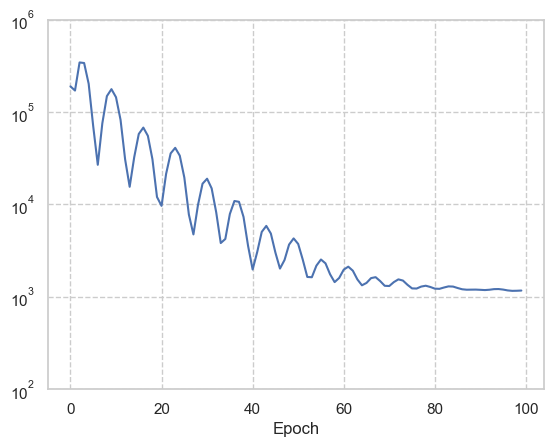

In [21]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(model_history.history['val_loss'])

plt.xlabel('Epoch')

plt.ylim(100, 1000000)
plt.yscale('log')

Text(0.5, 0, 'Epoch')

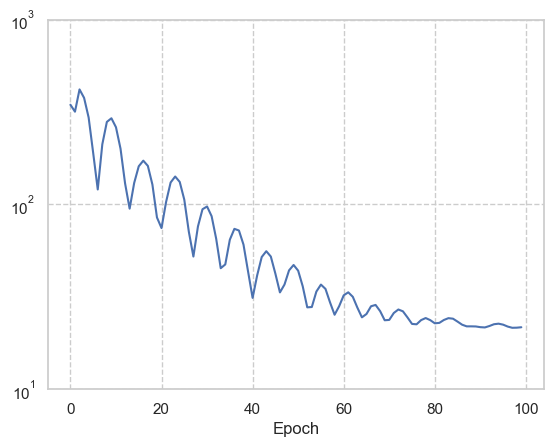

In [22]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(model_history.history['val_mean_absolute_error'])

plt.yscale('log')
plt.ylim(10, 1000)
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

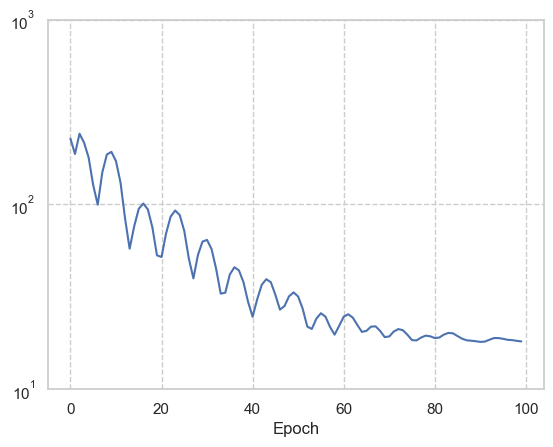

In [23]:
sns.set_theme(font_scale=1.0)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(model_history.history['val_mean_absolute_percentage_error'])

plt.yscale('log')
plt.ylim(10, 1000)
plt.xlabel('Epoch')

In [24]:
best_model = keras.models.load_model(os.path.join('models', f'lstm_model_{pred_distance}.keras'))

In [26]:
train_feature, train_target = create_lstm_dataset(train_dataset.to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=9)
val_feature, val_target = create_lstm_dataset(val_dataset.to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=9)
    
train_pred = np.squeeze(best_model.predict(train_feature, verbose=2))
val_pred = np.squeeze(best_model.predict(val_feature, verbose=2))

213/213 - 1s - 967ms/epoch - 5ms/step
54/54 - 0s - 221ms/epoch - 4ms/step


In [27]:
train_pred_label_list = []
val_pred_label_list = []

for i in range(10):
    train_pred_label_list.append(f'train_pred_{i}')
    val_pred_label_list.append(f'val_pred_{i}')

train_pred_pd = pd.DataFrame(data=train_pred, columns=train_pred_label_list)
train_dataset_result = pd.concat([train_dataset, train_pred_pd], axis=1)

val_pred_pd = pd.DataFrame(data=val_pred, columns=val_pred_label_list)
val_dataset_result = pd.concat([val_dataset, val_pred_pd], axis=1)

train_dataset_result.to_csv(os.path.join('logs', 'train_dataset_result.csv'))
val_dataset_result.to_csv(os.path.join('logs', 'val_dataset_result.csv'))

In [24]:
print(r2_score(np.stack(train_target, axis=1), np.stack(train_pred, axis=1)), 
      mean_absolute_error(np.stack(train_target, axis=1), np.stack(train_pred, axis=1)),
      mean_absolute_percentage_error(np.stack(train_target, axis=1), np.stack(train_pred, axis=1)))

-107165.50136176943 14.315569589231796 0.12163867611193467


In [25]:
print(r2_score(np.stack(val_target, axis=1), np.stack(val_pred, axis=1)),
      mean_absolute_error(np.stack(val_target, axis=1), np.stack(val_pred, axis=1)),
      mean_absolute_percentage_error(np.stack(val_target, axis=1), np.stack(val_pred, axis=1)))

0.8643705509639176 16.535007081889457 0.14525897984187897
